# Figure 5 - spatial and temporal coupling

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

# from collections import defaultdict

import h5py

# import cortex
import numpy as np

# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from surfplot import Plot

from scipy.spatial.distance import cdist
from sklearn.decomposition import NMF
from sklearn.preprocessing import LabelEncoder

from util import plot, subject
from util.path import Path
from util.atlas import Atlas  # , get_brainmask
from constants import SUBS_STRANGERS

# import warnings
# warnings.filterwarnings("ignore")

plt.style.use('figures.mplstyle')

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "model-gpt2-2b_layer-24"

features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding_trialmot6"
cache = encmodel.split("_")[-1]

modelname, encmodel, cache

('model-gpt2-2b_layer-24', 'encoding_trialmot6', 'trialmot6')

In [4]:
cachedir = f"cache/figure-mbc-lags/{modelname}/{cache}"
!mkdir -p $cachedir

In [5]:
catlas = Atlas.load("custom_glasser_group")
len(catlas)

22

In [6]:
lags = np.arange(-10, 11)
lags * 1.5

array([-15. , -13.5, -12. , -10.5,  -9. ,  -7.5,  -6. ,  -4.5,  -3. ,
        -1.5,   0. ,   1.5,   3. ,   4.5,   6. ,   7.5,   9. ,  10.5,
        12. ,  13.5,  15. ])

In [137]:
# subA prod pred -> subB comp actual
# by first shifting the signal, then taking out production time points, then correlating

sub_mbc_scores = []

# use subA's predictions on subB's actual neural data
for subA in tqdm(SUBS_STRANGERS):
    # load subA preds
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -2].reshape(1200, -1)
        prodmaskA = f["cv_prodmask"][...].ravel()

    # load subB preds
    subB = subject.get_partner(subA)
    encpath = Path(root=encmodel, sub=f"{subB:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        nuis_predsB = f["cv_preds"][:, :-2].sum(1).reshape(1200, -1)
    dataB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    resB = dataB - nuis_predsB

    predA = catlas.vox_to_parc(predA)
    resB = catlas.vox_to_parc(resB)

    sub_scores = np.zeros((10, len(lags), len(catlas), len(catlas)), dtype=np.float32)
    for k, t in enumerate(range(0, 1200, 120)):
        trial_slice = slice(t, t+120) 
        predA_trial = predA[trial_slice]
        resB_trial = resB[trial_slice]

        for i, lag in enumerate(lags):
            if lag < 0:
                trialA = predA_trial[:lag]
                trialB = resB_trial[-lag:]
                trialM = prodmaskA[trial_slice][:lag]
            elif lag > 0:
                trialA = predA_trial[lag:]
                trialB = resB_trial[:-lag]
                trialM = prodmaskA[trial_slice][lag:]
            else:
                trialA = predA_trial
                trialB = resB_trial
                trialM = prodmaskA[trial_slice]

            x = trialA[trialM]
            y = trialB[trialM]

            sub_scores[k, i] = cdist(x.T, y.T, metric='correlation')

    sub_mbc_scores.append(sub_scores)

    # break

sub_mbc_prod = np.stack(sub_mbc_scores)
sub_mbc_prod.shape

 24%|██▍       | 14/58 [01:03<02:59,  4.08s/it]/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/scipy/spatial/distance.py:152: RuntimeWarning: Mean of empty slice.
  XA = XA - XA.mean(axis=1, keepdims=True)
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: divide by zero encountered in divide
  ret = um.true_divide(
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/scipy/spatial/distance.py:153: RuntimeWarning: Mean of empty slice.
  XB = XB - XB.mean(axis=1, keepdims=True)
100%|██████████| 58/58 [04:16<00:00,  4.43s/it]


(58, 10, 21, 22, 22)

In [155]:
# save
with h5py.File(f"{cachedir}/mbc-prod_pred-actual-trial.hdf5", "w") as f:
    f.create_dataset(name="sub_mbc_prod", data=sub_mbc_prod)

In [7]:
# read
with h5py.File(f"{cachedir}/mbc-prod_pred-actual.hdf5", "r") as f:
    sub_mbc_prod = f["sub_mbc_prod"][...]
sub_mbc_prod.shape

(58, 5, 21, 22, 22)

# plot

In [8]:
import pandas as pd

In [9]:
sub_mbc_prod = np.nan_to_num(sub_mbc_prod, copy=False)

In [10]:
avg_mbc = (1 - sub_mbc_prod).mean((0,1))
avg_mbc.shape

(21, 22, 22)

In [11]:
inter_roi = avg_mbc.reshape(len(lags), -1).T
print(inter_roi.shape)
order = inter_roi.argmax(1).argsort()

(484, 21)


In [12]:
flat_labels = []
for label1 in catlas.labels:
    for label2 in catlas.labels:
        flat_labels.append(label1 + '-' + label2)
len(flat_labels)

484

In [54]:
roi2level = {
    'LangS': 'misc',
    'MOT': 'low',
    'AUD': 'low',
    'LangT': 'low',
    'LangPT': 'high',
    'TPJ': 'high',
    'LangMFG': 'low',
    'LangF': 'high',
    'MOTS': 'misc',
    'Misc': 'misc',
    'DMN': 'high'
}

roi2net = {
    'LangS': 'misc',
    'MOT': 'temporal',
    'AUD': 'temporal',
    'LangT': 'temporal',
    'LangPT': 'ag',
    'TPJ': 'ag',
    'LangMFG': 'frontal',
    'LangF': 'frontal',
    'MOTS': 'frontal',
    'Misc': 'misc',
    'DMN': 'medial'
}

In [13]:
df = pd.DataFrame()
df['label'] = flat_labels
df['spk_hemi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[0])
df['lst_hemi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[0])
df['spk_roi'] = df.label.apply(lambda x: x.split('-')[0].split('_')[1])
df['lst_roi'] = df.label.apply(lambda x: x.split('-')[1].split('_')[1])
df['peak_lag'] = inter_roi.argmax(1)
df['peak_r'] = inter_roi.max(1)
df.sample(10)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
368,RH_TPJ-RH_TPJ,RH,RH,TPJ,TPJ,10,0.074108
132,LH_LangMFG-LH_LangS,LH,LH,LangMFG,LangS,14,0.019177
297,RH_AUD-RH_LangS,RH,RH,AUD,LangS,12,0.057968
402,RH_LangF-LH_LangMFG,RH,LH,LangF,LangMFG,11,0.085551
266,RH_MOT-LH_AUD,RH,LH,MOT,AUD,10,0.041407
442,RH_Misc-LH_AUD,RH,LH,Misc,AUD,9,0.045723
213,LH_Misc-RH_LangPT,LH,RH,Misc,LangPT,10,0.081015
287,RH_AUD-LH_MOT,RH,LH,AUD,MOT,12,0.049824
234,LH_DMN-RH_LangT,LH,RH,DMN,LangT,8,0.065645
235,LH_DMN-RH_LangPT,LH,RH,DMN,LangPT,10,0.082775


In [47]:
# df.sort_values(['peak_lag', 'spk_hemi', 'spk_roi', 'lst_hemi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'spk_roi', 'lst_roi'], inplace=True)
# df.sort_values(['peak_lag', 'lst_roi', 'spk_roi'], inplace=True)
# df.sort_values(['spk_roi', 'lst_roi'], inplace=True)
df.sort_values('peak_lag', inplace=True)

order = df.index.to_numpy()

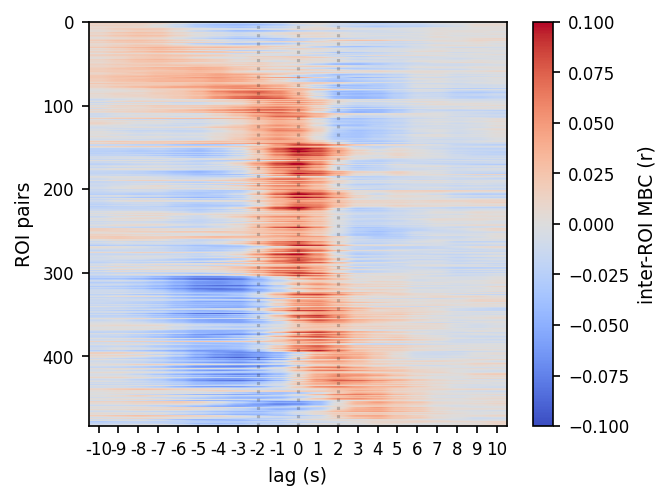

In [49]:
fig, ax = plt.subplots(figsize=(4.5, 3.5))
im = ax.imshow(inter_roi[order], cmap='coolwarm', vmin=-.1, vmax=.1, aspect='auto')
# ax.set_yticks([])
ax.set_xticks(range(len(lags)), labels=lags)
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.set_ylabel('ROI pairs')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
cbar = fig.colorbar(im)
cbar.set_label('inter-ROI MBC (r)')
fig.show()

## plot individual trajectories

In [231]:
import plotly.express as px

In [213]:
maxes = inter_roi[order].max(-1)
maxes.shape

(484,)

In [214]:
print(order[maxes[:150].argsort()[-10:]])

print(order[maxes[150:280].argsort()[-10:] + 150])

print(order[maxes[300:].argsort()[-10:] + 300])

[300 388 432 476 456 410 322 256 366 344]
[195 426 413 433 435 411 345 415 349 437]
[363 336 358 341 479 360 338 369 371 347]


In [251]:
df

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
64,LH_AUD-RH_Misc,LH,RH,AUD,Misc,0,0.008363
86,LH_LangT-RH_Misc,LH,RH,LangT,Misc,0,0.006443
54,LH_AUD-LH_DMN,LH,LH,AUD,DMN,1,0.014154
65,LH_AUD-RH_DMN,LH,RH,AUD,DMN,1,0.009895
296,RH_AUD-LH_DMN,RH,LH,AUD,DMN,1,0.017322
...,...,...,...,...,...,...,...
73,LH_LangT-LH_LangF,LH,LH,LangT,LangF,16,0.009580
155,LH_LangF-LH_MOT,LH,LH,LangF,MOT,20,0.009837
166,LH_LangF-RH_MOT,LH,RH,LangF,MOT,20,0.007120
386,RH_LangMFG-RH_MOT,RH,RH,LangMFG,MOT,20,0.013509


In [254]:
df[df.peak_lag == 9].sort_values('peak_r', ascending=False).head(50)

,label,spk_hemi,lst_hemi,spk_roi,lst_roi,peak_lag,peak_r
256,RH_LangS-RH_LangT,RH,RH,LangS,LangT,9,0.081829
322,RH_LangT-RH_LangT,RH,RH,LangT,LangT,9,0.080451
456,RH_Misc-RH_TPJ,RH,RH,Misc,TPJ,9,0.076465
300,RH_AUD-RH_LangT,RH,RH,AUD,LangT,9,0.071753
214,LH_Misc-RH_TPJ,LH,RH,Misc,TPJ,9,0.068319
58,LH_AUD-RH_LangT,LH,RH,AUD,LangT,9,0.065168
343,RH_LangPT-RH_AUD,RH,RH,LangPT,AUD,9,0.062915
332,RH_LangPT-LH_AUD,RH,LH,LangPT,AUD,9,0.062231
151,LH_LangMFG-RH_MOTS,LH,RH,LangMFG,MOTS,9,0.061876
461,RH_Misc-RH_DMN,RH,RH,Misc,DMN,9,0.061595


In [252]:
# https://stackoverflow.com/questions/73649907/plotly-express-imshow-hover-text/73658192#73658192
fig = px.imshow(inter_roi[order],
                y=flat_labels,
                aspect='auto',
                color_continuous_scale='RdBu_r',
                height=800,
                )
fig.update_yaxes(showticklabels=False)
fig.show()

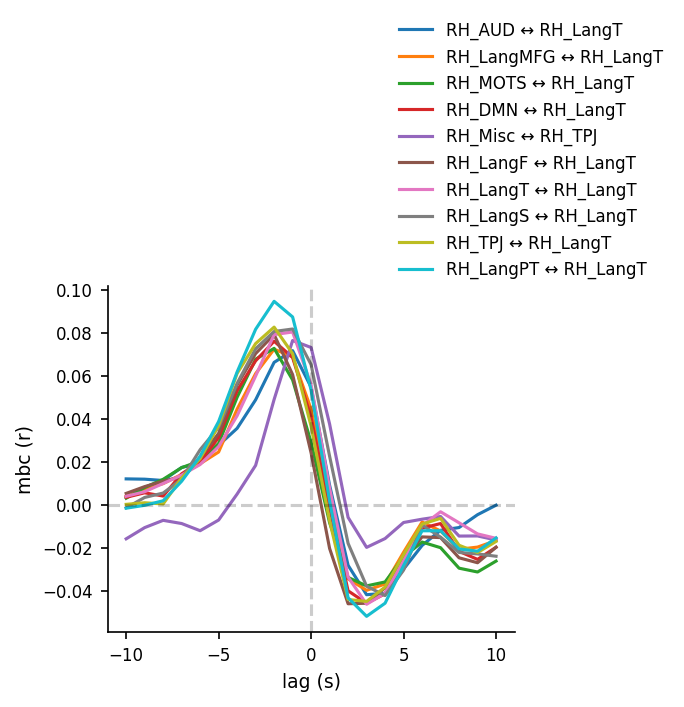

In [218]:
fig, ax = plt.subplots(figsize=(3.5, 3))

# for i in [256, 366, 344]:  # group 1 top 3
# for i in [415, 349, 437]:  # group 2 top 3
# for i in [338, 369, 347]:  # group 2 top 3
for i in [300, 388, 432, 476, 456, 410, 322, 256, 366, 344]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k', alpha=0.2, ls='dashed')
ax.axhline(0, c='k', alpha=0.2, ls='dashed')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

## try clustering

In [31]:
model = NMF(n_components=3, max_iter=1000)
W = model.fit_transform(1 - inter_roi)
H = model.components_
labels = W.argmax(-1)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


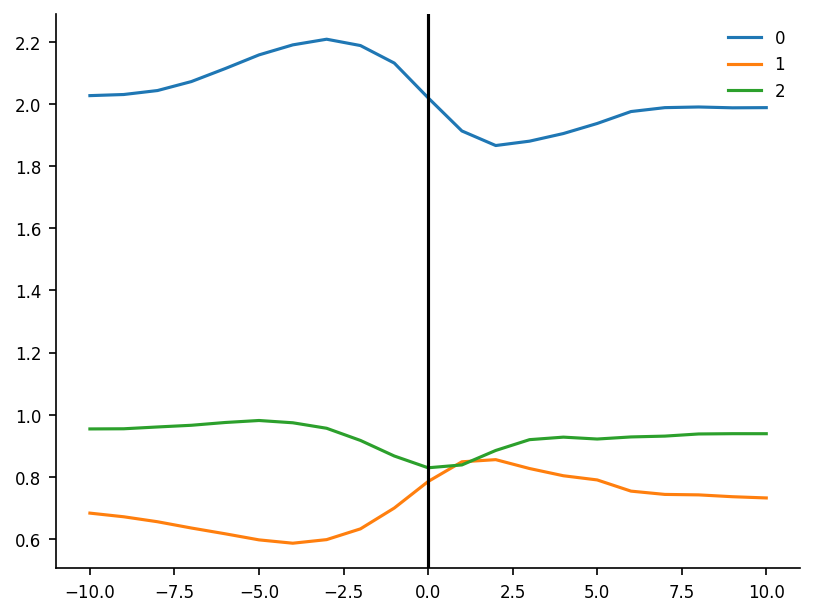

In [35]:
for i in range(model.n_components_):
    plt.plot(lags, H[i], label=i)
plt.axvline(0, c='k')
plt.legend()
plt.show()

## plot label map

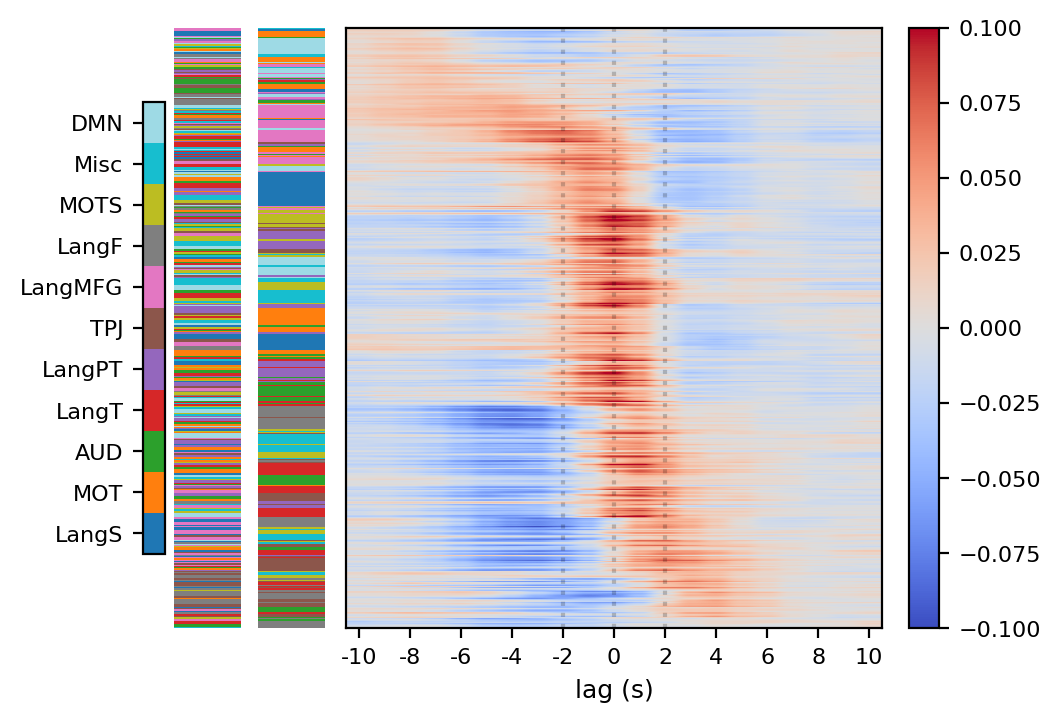

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(5.2, 3.5), width_ratios=[.1, .1, .8], sharey=True, dpi=200, layout='constrained')

colormap = 'tab20'

values = LabelEncoder().fit_transform(df.spk_roi)
ax = axes[0]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

values = LabelEncoder().fit_transform(df.lst_roi)
ax = axes[1]
cmap = plt.get_cmap(colormap, np.max(values) - np.min(values) + 1)
im = ax.imshow(values.reshape(-1, 1), aspect='auto', cmap=cmap, vmin=values.min()-.5, vmax=values.max()+.5, interpolation='nearest')
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])

cbar = fig.colorbar(im, ax=axes[:2], location='left', ticks=np.arange(np.min(values), np.max(values) + 1))
cbar.ax.set_yticklabels([label.split('_')[1] for label in catlas.labels[:11]])

ax = axes[2]
im2 = ax.imshow(inter_roi[order], cmap='coolwarm', vmin=-.1, vmax=.1, aspect='auto', interpolation=None)
ax.set_xticks(range(0, len(lags), 2), labels=lags[::2])
ax.set_yticks([])
ax.axvline(10, c='k', ls='dotted', alpha=0.2)
ax.axvline(10-2, c='k', ls='dotted', alpha=0.2)
ax.axvline(10+2, c='k', ls='dotted', alpha=0.2)
ax.set_xlabel('lag (s)')
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

cbar = fig.colorbar(im2, ax=axes[2])

fig.show()

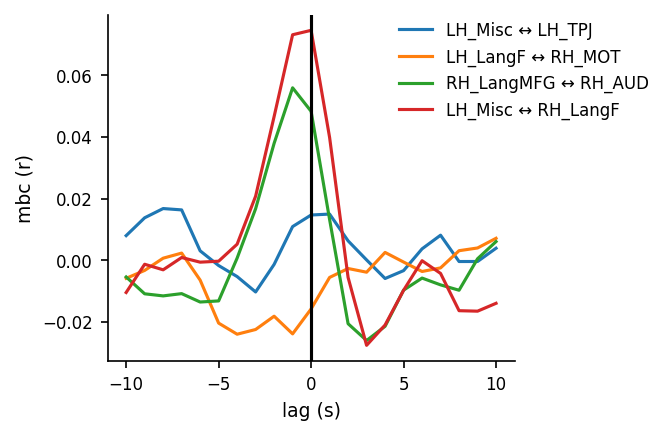

In [122]:
fig, ax = plt.subplots(figsize=(3.5, 3))

# for i in [415, 349, 437]:
# for i in [5, 1, 59]:
# for i in [433, 437, 435]:
# for i in [181, 213, 169]:
for i in [203, 166, 387, 216]:
    r, c = np.unravel_index(i, shape=(22, 22))
    label = catlas.labels[r] + ' ↔ ' + catlas.labels[c]
    ax.plot(lags, inter_roi[i], label=label)

ax.axvline(0, c='k')
ax.set_xlabel('lag (s)')
ax.set_ylabel('mbc (r)')
ax.legend(bbox_to_anchor=(.7, 1), borderaxespad=0)
fig.show()

In [13]:
hemi = 'RH'
seed = 'LangT'
networks = [['AUD', 'LangT', 'LangPT'], ['LangMFG', 'LangF', 'DMN']]

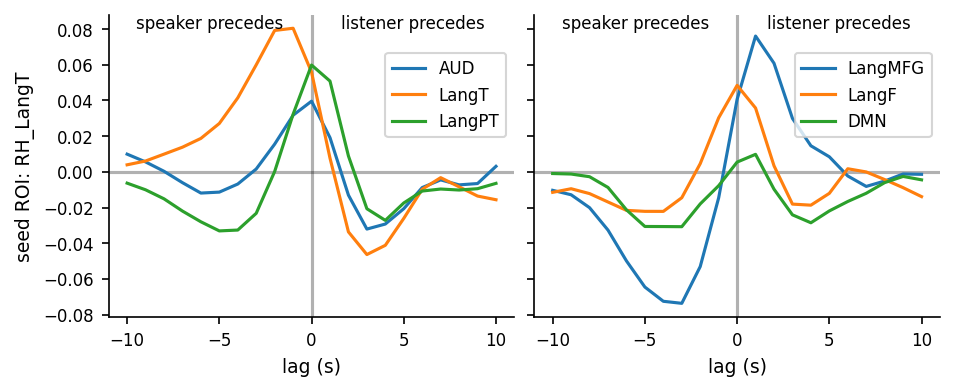

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(6.25, 2.5), sharex=True, sharey=True, layout='constrained')

seedROI = f'{hemi}_{seed}'
seedId = catlas[seedROI] - 1

for ax, nets in zip(axes, networks):
    ax.axvline(0, c="k", alpha=0.3)
    ax.axhline(0, c="k", alpha=0.3)

    for net in nets:
        targetROI = f'{hemi}_{net}'
        targetid = catlas[targetROI] - 1
        values = avg_mbc[:, seedId, targetid]
        ax.plot(lags, values, label=net)
        # print(seedROI, seedId, targetROI, targetid)

    ax.text(0.25, 1, "speaker precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.text(0.75, 1, "listener precedes", transform=ax.transAxes, verticalalignment="top", horizontalalignment="center", fontsize=8)
    ax.legend(frameon=True, loc='upper right', bbox_to_anchor=(1, 0.9))
    # ax.legend(frameon=True, loc='upper center', ncols=3, bbox_to_anchor=(0.5, -0.2))
    ax.set_xlabel('lag (s)')

axes[0].set_ylabel(f'seed ROI: {seedROI}')

fig.show()

# plot seed ROI

In [98]:
seeds = ['RH_LangPT', 'RH_LangF', 'RH_DMN']

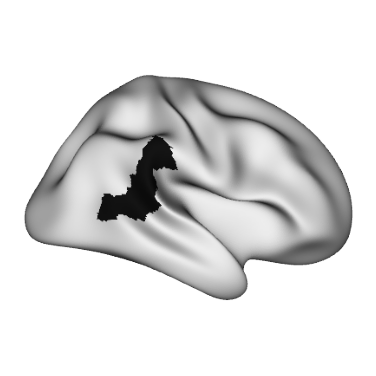

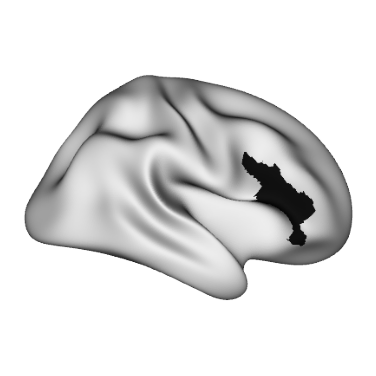

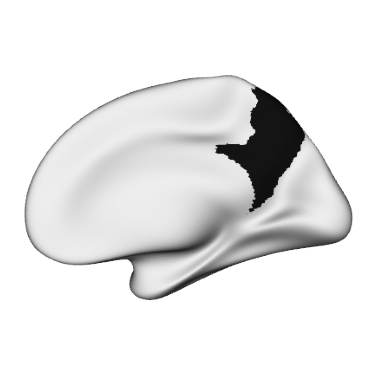

In [122]:
for seed in seeds:
    seedId = catlas[seed]
    roimask = catlas.roimask([seedId]).astype(int)

    view = 'lateral'
    if 'LangS' in seed or 'DMN' in seed:
        view = 'medial'
    # print(seed, seedId, roimask.sum(), view)

    p = Plot(surf_rh="mats/suma-fsaverage6/rh.inf_120.gii", views=view, brightness=0.7, size=(200, 200), zoom=1.2)
    p.add_layer({'right': roimask[roimask.size//2:]}, cmap='Grays', color_range=(0, 1), cbar=False)
    fig = p.build()
    fig.show()